# Deep Neural Network for MNIST Classification

We'll apply all the knowledge from the lectures in this section to write a deep neural network. The problem we've chosen is referred to as the "Hello World" of deep learning because for most students it is the first deep learning algorithm they see.

The dataset is called MNIST and refers to handwritten digit recognition. You can find more about it on Yann LeCun's website (Director of AI Research, Facebook). He is one of the pioneers of what we've been talking about and of more complex approaches that are widely used today, such as covolutional neural networks (CNNs). 

The dataset provides 70,000 images (28x28 pixels) of handwritten digits (1 digit per image). 

The goal is to write an algorithm that detects which digit is written. Since there are only 10 digits (0, 1, 2, 3, 4, 5, 6, 7, 8, 9), this is a classification problem with 10 classes. 

Our goal would be to build a neural network with 2 hidden layers.

IMporting the packages

In [ ]:
import numpy as np
import tensorflow as tf

# TensorFLow includes a data provider for MNIST that we'll use.


import tensorflow_datasets as tfds

# these datasets will be stored in C:\Users\*USERNAME*\tensorflow_datasets\...
# every other time, it is automatically loading the copy on your computer 

In [ ]:

# these datasets will be stored in C:\Users\*USERNAME*\tensorflow_datasets\...
# the first time you download a dataset, it is stored in the respective folder 
# every other time, it is automatically loading the copy on your computer 


# mnist_dataset = tfds.load(name='mnist', as_supervised=True)
mnist_dataset, mnist_info = tfds.load(name='mnist', with_info=True, as_supervised=True)
# with_info=True will also provide us with a tuple containing information about the version, features, number of samples
# we will use this information a bit below and we will store it in mnist_info

# as_supervised=True will load the dataset in a 2-tuple structure (input, target) 
# alternatively, as_supervised=False, would return a dictionary
# obviously we prefer to have our inputs and targets separated 

In [ ]:
print(mnist_info)

In [ ]:
# once we have loaded the dataset, we can easily extract the training and testing dataset with the built references
mnist_train, mnist_test = mnist_dataset['train'], mnist_dataset['test']

# by default, TF has training and testing datasets, but no validation sets


# we start by defining the number of validation samples as a % of the train samples
# this is also where we make use of mnist_info (we don't have to count the observations)
num_validation_samples = 0.1 * mnist_info.splits['train'].num_examples
# let's cast this number to an integer, as a float may cause an error along the way
num_validation_samples = tf.cast(num_validation_samples, tf.int64)


# let's also store the number of test samples in a dedicated variable (instead of using the mnist_info one)
num_test_samples = mnist_info.splits['test'].num_examples
# once more, we'd prefer an integer (rather than the default float)
num_test_samples = tf.cast(num_test_samples, tf.int64)


# normally, we would like to scale our data in some way to make the result more numerically stable
# in this case we will simply prefer to have inputs between 0 and 1
# let's define a function called: scale, that will take an MNIST image and its label

def scale(image, label):
    # we make sure the value is a float
    image = tf.cast(image, tf.float32)
    # since the possible values for the inputs are 0 to 255 (256 different shades of grey)
    # if we divide each element by 255, we would get the desired result -> all elements will be between 0 and 1 
    image /= 255.

    return image, label


# the method .map() allows us to apply a custom transformation to a given dataset
# we have already decided that we will get the validation data from mnist_train, so 
scaled_train_and_validation_data = mnist_train.map(scale)

# finally, we scale and batch the test data
# we scale it so it has the same magnitude as the train and validation
# there is no need to shuffle it, because we won't be training on the test data
# there would be a single batch, equal to the size of the test data
test_data = mnist_test.map(scale)

In [ ]:

# let's also shuffle the data

BUFFER_SIZE = 10000
# this BUFFER_SIZE parameter is here for cases when we're dealing with enormous datasets
# then we can't shuffle the whole dataset in one go because we can't fit it all in memory
# so instead TF only stores BUFFER_SIZE samples in memory at a time and shuffles them
# if BUFFER_SIZE=1 => no shuffling will actually happen
# if BUFFER_SIZE >= num samples => shuffling is uniform
# BUFFER_SIZE in between - a computational optimization to approximate uniform shuffling

# luckily for us, there is a shuffle method readily available and we just need to specify the buffer size
shuffled_train_and_validation_data = scaled_train_and_validation_data.shuffle(BUFFER_SIZE)

# once we have scaled and shuffled the data, we can proceed to actually extracting the train and validation
# our validation data would be equal to 10% of the training set, which we've already calculated
# we use the .take() method to take that many samples
# finally, we create a batch with a batch size equal to the total number of validation samples
validation_data = shuffled_train_and_validation_data.take(num_validation_samples)

# similarly, the train_data is everything else, so we skip as many samples as there are in the validation dataset
train_data = shuffled_train_and_validation_data.skip(num_validation_samples)

# determine the batch size
BATCH_SIZE = 100

# we can also take advantage of the occasion to batch the train data
# this would be very helpful when we train, as we would be able to iterate over the different batches
train_data = train_data.batch(BATCH_SIZE)

validation_data = validation_data.batch(num_validation_samples)

# batch the test data
test_data = test_data.batch(num_test_samples)


# takes next batch (it is the only batch)
# because as_supervized=True, we've got a 2-tuple structure
validation_inputs, validation_targets = next(iter(validation_data))

In [ ]:
input_size=784
output_size=10

hiddenlay=(50,75,100,125)
depthlay=(2,3,4,5,7,8,10)
activate=('ReLU', 'Leaky','ReLU', 'Sigmoid','Tanh')

In [ ]:
import matplotlib.pyplot as plt

def model_function(i, input_data, output_data, hiddenlays, depthlays, activates, NUM_EPOCHS):
    print(f"\n========== Model {i} ==========")
    print(f"Hidden Layer Size  : {hiddenlays}")
    print(f"Number of Layers   : {depthlays}")
    print(f"Activation Function: {activates}")
    print(f"Epochs             : {NUM_EPOCHS}")
    print("===============================\n")

    layers = [tf.keras.layers.Flatten(input_shape=(28, 28, 1))]

    if activates.lower() == 'leaky_relu':
        for _ in range(depthlays):
            layers.append(tf.keras.layers.Dense(hiddenlays))
            layers.append(tf.keras.layers.LeakyReLU())
    else:
        for _ in range(depthlays):
            layers.append(tf.keras.layers.Dense(hiddenlays, activation=activates.lower()))

    layers.append(tf.keras.layers.Dense(10, activation='softmax'))

    model = tf.keras.Sequential(layers)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train and save history
    history = model.fit(
        input_data,
        epochs=NUM_EPOCHS,
        validation_data=output_data,
        verbose=2
    )

    return model, history




In [ ]:
def plot_training_graph(history, model_index):
    plt.figure(figsize=(12, 5))
    
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Model {model_index} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Model {model_index} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [36]:
hiddenlay = [60]
depthlay = [4]
activate = 'relu'
epochs_list = [30]  # More values than models, will trim to match

# Adjust to shortest length to avoid mismatch
min_models = min(len(hiddenlay), len(depthlay), len(epochs_list))



========== Model 1 ==========
Hidden Layer Size  : 60
Number of Layers   : 4
Activation Function: relu
Epochs             : 30

Epoch 1/30
540/540 - 3s - 5ms/step - accuracy: 0.8873 - loss: 0.3760 - val_accuracy: 0.9537 - val_loss: 0.1562
Epoch 2/30
540/540 - 2s - 3ms/step - accuracy: 0.9569 - loss: 0.1481 - val_accuracy: 0.9620 - val_loss: 0.1265
Epoch 3/30
540/540 - 2s - 3ms/step - accuracy: 0.9650 - loss: 0.1142 - val_accuracy: 0.9723 - val_loss: 0.0939
Epoch 4/30
540/540 - 2s - 3ms/step - accuracy: 0.9716 - loss: 0.0915 - val_accuracy: 0.9762 - val_loss: 0.0767
Epoch 5/30
540/540 - 2s - 3ms/step - accuracy: 0.9762 - loss: 0.0781 - val_accuracy: 0.9807 - val_loss: 0.0713
Epoch 6/30
540/540 - 2s - 3ms/step - accuracy: 0.9792 - loss: 0.0679 - val_accuracy: 0.9800 - val_loss: 0.0635
Epoch 7/30
540/540 - 2s - 3ms/step - accuracy: 0.9826 - loss: 0.0552 - val_accuracy: 0.9835 - val_loss: 0.0576
Epoch 8/30
540/540 - 2s - 3ms/step - accuracy: 0.9849 - loss: 0.0491 - val_accuracy: 0.9868 - 

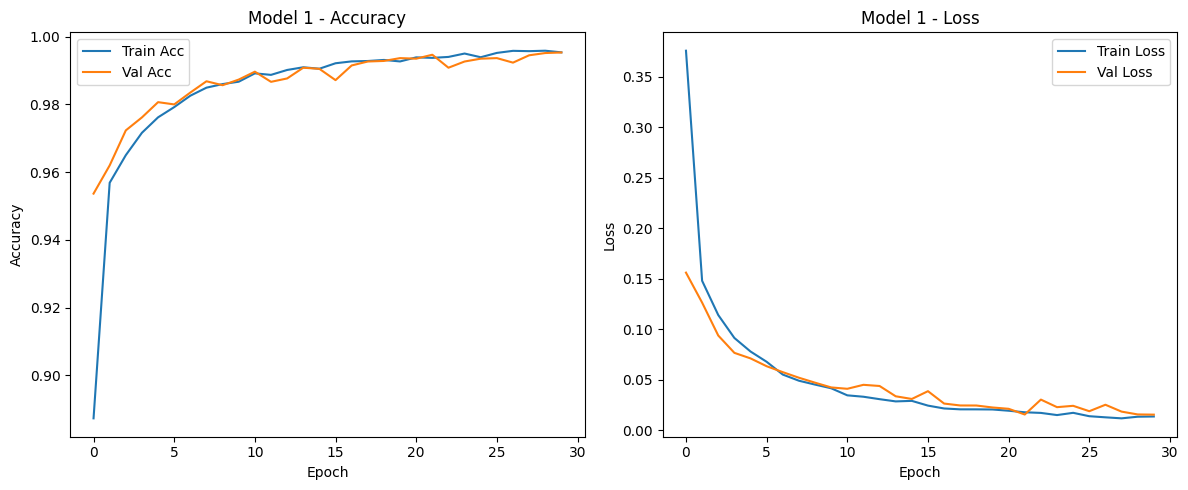

In [37]:
models = []
histories = []

for i in range(min_models):
    model, history = model_function(
        i=i+1,
        input_data=train_data,
        output_data=(validation_inputs, validation_targets),
        hiddenlays=hiddenlay[i],
        depthlays=depthlay[i],
        activates=activate,
        NUM_EPOCHS=epochs_list[i]
    )
    models.append(model)
    histories.append(history)

    plot_training_graph(history, model_index=i+1)





In [38]:
test_loss, test_accuracy = model.evaluate(test_data)
print('Test loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.9750 - loss: 0.1328
Test loss: 0.13. Test accuracy: 97.50%
